In [20]:
# autoreload -- Use for development only
%load_ext autoreload
%autoreload 2

# Training models for plant promoter prediction

# Step 0: Set-up

In [1]:
# Double check you have a GPU available
import torch
torch.cuda.is_available()

True

In [2]:
# Define any useful paths
import os
cwd = "/cellar/users/aklie/projects/ML4GLand/use_cases/jores21"

# Load leaf data and motifs 

In [3]:
import seqdata as sd
import motifdata as md
from copy import deepcopy 

# Load in the preprocessed training data
sdata_leaf = sd.read_h5sd(os.path.join(cwd, "data", "paper_github", "train_sdata.h5sd"))

# Grab motifs
core_promoter_elements = md.read_meme(os.path.join(cwd, "data", "paper_github", "CPEs.meme"))
tf_clusters = md.read_meme(os.path.join(cwd, "data", "paper_github", "TF-clusters.meme"))

# Smush them together, make function in the future
all_motifs = deepcopy(core_promoter_elements)
for motif in tf_clusters:
    all_motifs.add_motif(motif)

# Print the data
sdata_leaf, all_motifs

(SeqData object with = 65004 seqs
 seqs = (65004,)
 names = (65004,)
 rev_seqs = None
 ohe_seqs = None
 ohe_rev_seqs = None
 seqs_annot: 'enrichment', 'gene', 'set', 'sp'
 pos_annot: None
 seqsm: None
 uns: None,
 MotifSet with 78 motifs)

# Instantiate model architecture

In [4]:
from eugene import models
config_dir = os.path.join(cwd, "configs")

In [5]:
model = models.load_config(os.path.join(config_dir, "grace.yaml"))
models.init_weights(model)
model.summary()

Model: Hybrid
Sequence length: 170
Output dimension: 1
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {'patience': 2}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name            | Type           | Params
---------------------------------------------------
0 | train_metric    | R2Score        | 0     
1 | val_metric      | R2Score        | 0     
2 | test_metric     | R2Score        | 0     
3 | conv1d_tower    | Conv1DTower    | 1.7 M 
4 | recurrent_block | RecurrentBlock | 197 K 
5 | dense_block     | DenseBlock     | 8.4 K 
---------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.703     Total estimated model params size (MB)

In [6]:
model.scheduler.__dict__

mappingproxy({'__module__': 'torch.optim.lr_scheduler',
              '__doc__': "Reduce learning rate when a metric has stopped improving.\n    Models often benefit from reducing the learning rate by a factor\n    of 2-10 once learning stagnates. This scheduler reads a metrics\n    quantity and if no improvement is seen for a 'patience' number\n    of epochs, the learning rate is reduced.\n\n    Args:\n        optimizer (Optimizer): Wrapped optimizer.\n        mode (str): One of `min`, `max`. In `min` mode, lr will\n            be reduced when the quantity monitored has stopped\n            decreasing; in `max` mode it will be reduced when the\n            quantity monitored has stopped increasing. Default: 'min'.\n        factor (float): Factor by which the learning rate will be\n            reduced. new_lr = lr * factor. Default: 0.1.\n        patience (int): Number of epochs with no improvement after\n            which learning rate will be reduced. For example, if\n            `pa

# Initialize parameters

In [7]:
models.init_motif_weights(
    model,
    layer_name="conv1d_tower.layers.0",
    motifs=all_motifs
)

In [8]:
# Double check that layer
from eugene.models.base._utils import get_layer
get_layer(model, 'conv1d_tower.layers.0').weight[0].T

tensor([[0.5100, 1.5060, 0.4780, 1.5060],
        [0.6300, 1.5940, 0.7960, 0.9820],
        [0.9960, 1.2120, 0.7880, 1.0040],
        [0.4940, 2.6200, 0.3020, 0.5820],
        [0.0400, 0.0080, 0.0080, 3.9440],
        [3.8720, 0.0000, 0.0000, 0.1280],
        [0.0080, 0.0560, 0.0240, 3.9120],
        [3.9680, 0.0000, 0.0080, 0.0240],
        [2.6120, 0.0480, 0.0080, 1.3320],
        [3.8960, 0.0000, 0.0320, 0.0720],
        [1.3640, 0.1120, 0.1440, 2.3820],
        [2.7820, 0.3260, 0.4780, 0.4140],
        [0.5020, 1.7280, 1.2660, 0.5020]], grad_fn=<PermuteBackward0>)

# Train leaf models

In [9]:
import numpy as np
from eugene import dataload as dl
from eugene import preprocess as pp
from eugene import train

In [10]:
pp.ohe_seqs_sdata(sdata_leaf)
pp.train_test_split_sdata(sdata_leaf, split=0.9)

One-hot encoding sequences:   0%|          | 0/65004 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 65004 ohe_seqs added
SeqData object modified:
    seqs_annot:
        + train_val


In [11]:
train_idx = np.where(sdata_leaf["train_val"] == True)[0]
val_idx = np.where(sdata_leaf["train_val"] == False)[0]
train_sdataset = dl.SequenceDataset(
    seqs=sdata_leaf.ohe_seqs[train_idx],
    targets=sdata_leaf["enrichment"].values[train_idx],
    transforms=dl.ReverseComplement(p=0.0)
)
val_sdataset = dl.SequenceDataset(
    seqs=sdata_leaf.ohe_seqs[val_idx],
    targets=sdata_leaf["enrichment"].values[val_idx],
    transforms=dl.ReverseComplement(p=0.0)
)

In [12]:
train_sdataloader = train_sdataset.to_dataloader(batch_size=128, shuffle=True, num_workers=2, drop_last=True)
val_sdataloader = val_sdataset.to_dataloader(batch_size=128, shuffle=False, num_workers=2, drop_last=True)

In [13]:
train.fit(
    model=model, 
    train_dataloader=train_sdataloader,
    val_dataloader=val_sdataloader,
    gpus=1, 
    epochs=50,
    logger="csv",
    log_dir=os.path.join(cwd, "models"),
    name="grace",
    version="leaf"
)

No seed set


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0

Sanity Checking: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [14]:
import pandas as pd
import seaborn as sns
from eugene import plot as pl

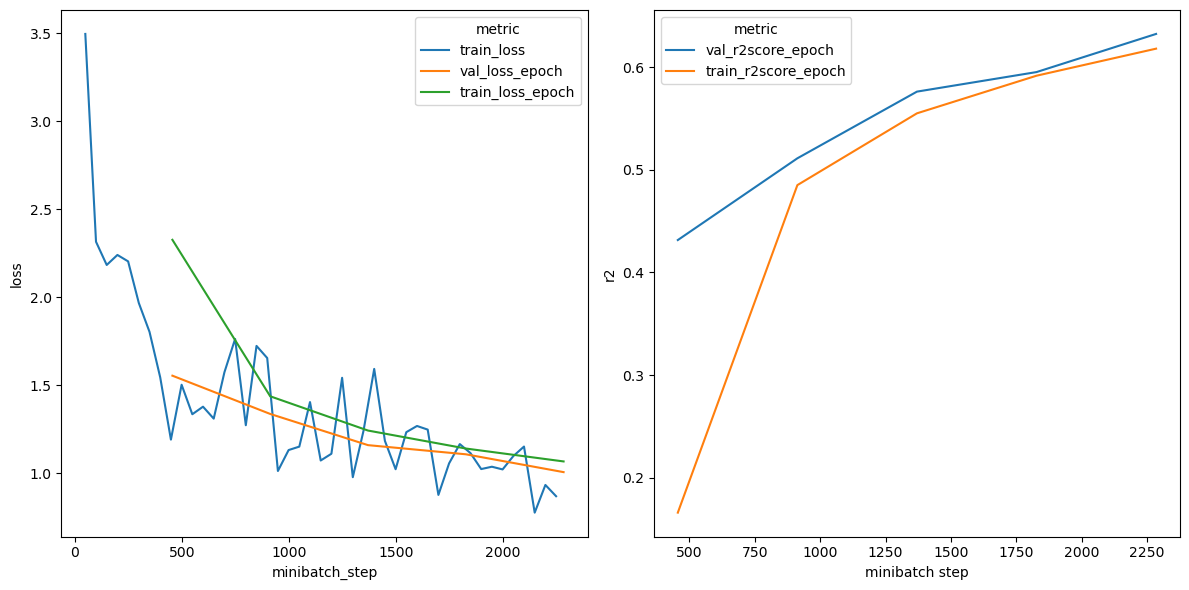

In [24]:
pl.training_summary(os.path.join(cwd, "models", "grace", "leaf"))

In [15]:
training_summary = pd.read_csv(os.path.join(cwd, "models", "grace", "leaf", "metrics.csv"))

In [16]:
# Grab all columns that have the "epoch" or "step" in them
epoch_cols = [col for col in training_summary.columns if "epoch" in col]

epoch_summary = training_summary[epoch_cols]

In [17]:
metric_names = ["r2score"]
metric_cols = [col for col in epoch_summary.columns if any([metric in col for metric in metric_names])]
loss_cols = [col for col in epoch_summary.columns if "loss" in col]

# Separate out the loss and metric
loss_summary = epoch_summary[["epoch"] + loss_cols]
metric_summary = epoch_summary[["epoch"] + metric_cols]

In [18]:
loss_summary_long = loss_summary.melt(
    id_vars=["epoch"],
    value_vars=loss_cols,
)
loss_summary_long[~loss_summary_long["value"].isna()]

,epoch,variable,value
10,0.0,val_loss_epoch,1.613551
22,1.0,val_loss_epoch,1.248527
34,2.0,val_loss_epoch,1.132046
46,3.0,val_loss_epoch,1.025387
58,4.0,val_loss_epoch,0.939486
70,5.0,val_loss_epoch,0.957103
82,6.0,val_loss_epoch,0.929148
95,7.0,val_loss_epoch,0.979620
107,8.0,val_loss_epoch,0.942731
119,9.0,val_loss_epoch,0.938706


In [19]:
metric_summary_long = metric_summary.melt(
    id_vars=["epoch"],
    value_vars=metric_cols,
)
metric_summary_long[~metric_summary_long["value"].isna()]

,epoch,variable,value
10,0.0,val_r2score_epoch,0.409606
22,1.0,val_r2score_epoch,0.543168
34,2.0,val_r2score_epoch,0.585788
46,3.0,val_r2score_epoch,0.624814
58,4.0,val_r2score_epoch,0.656245
70,5.0,val_r2score_epoch,0.649799
82,6.0,val_r2score_epoch,0.660027
95,7.0,val_r2score_epoch,0.641560
107,8.0,val_r2score_epoch,0.655057
119,9.0,val_r2score_epoch,0.656530


In [20]:
import matplotlib.pyplot as plt

<AxesSubplot: xlabel='epoch', ylabel='value'>

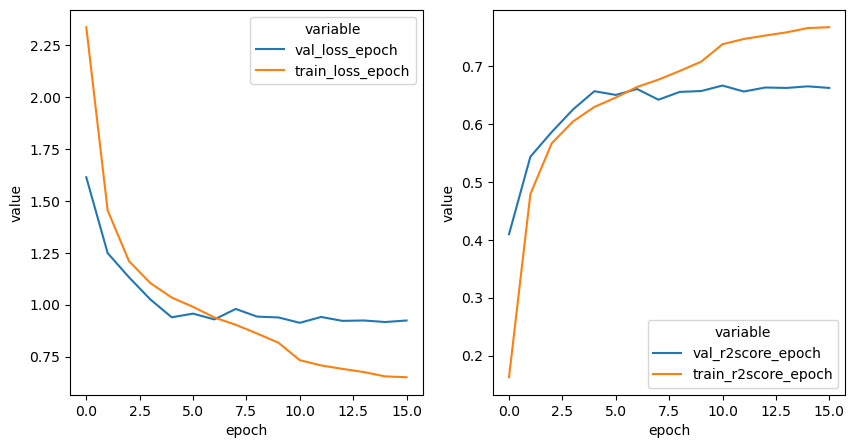

In [21]:
# Plot the epoch loss and metrics side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(
    data=loss_summary_long,
    x="epoch",
    y="value",
    hue="variable",
    ax=axes[0]
)
sns.lineplot(
    data=metric_summary_long,
    x="epoch",
    y="value",
    hue="variable",
    ax=axes[1]
)

In [ ]:
# Get columns with metric
metric_cols = [col for col in training_summary.columns if metric in col]

# Get columns for train_loss_epoch and val_loss
epoch_loss_cols = ["train_loss_epoch", "val_loss"]

In [96]:
training_summary

,lr-Adam,step,train_loss_step,epoch,val_loss,val_r2score,train_loss_epoch,train_r2score
0,0.001,0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,49,2.631886,0.0,NaN,NaN,NaN,NaN
2,NaN,99,2.854498,0.0,NaN,NaN,NaN,NaN
3,NaN,149,2.421745,0.0,NaN,NaN,NaN,NaN
4,NaN,199,2.518469,0.0,NaN,NaN,NaN,NaN
5,NaN,249,2.033890,0.0,NaN,NaN,NaN,NaN
6,NaN,299,2.097217,0.0,NaN,NaN,NaN,NaN
7,NaN,349,1.834924,0.0,NaN,NaN,NaN,NaN
8,NaN,399,1.810262,0.0,NaN,NaN,NaN,NaN
9,NaN,449,2.067122,0.0,NaN,NaN,NaN,NaN


In [58]:
y

NameError: name 'y' is not defined

<AxesSubplot: xlabel='step', ylabel='train_loss'>

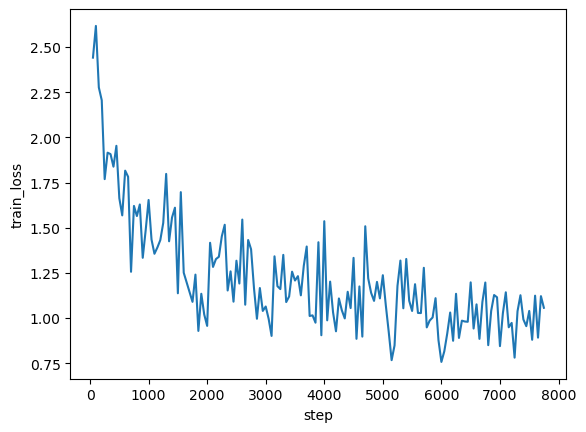

In [56]:
# plot train_loss
sns.lineplot(
    x="step",
    y="train_loss",
    data=training_summary
)

In [51]:
# want to plot per epoch loss and r2, need to pull those columns and remove NaNs
epoch_summary = training_summary[["epoch", "train_loss", "val_loss", "train_r2score_epoch", "val_r2score"]]

In [40]:
epoch_summary

,epoch,train_loss,val_loss,train_r2score_epoch,val_r2score
0,NaN,NaN,NaN,NaN,NaN
1,0.0,3.097897,NaN,NaN,NaN
2,0.0,2.657948,NaN,NaN,NaN
3,0.0,2.554789,NaN,NaN,NaN
4,0.0,2.619973,NaN,NaN,NaN
...,...,...,...,...,...
201,16.0,0.878020,NaN,NaN,NaN
202,16.0,0.877024,NaN,NaN,NaN
203,16.0,0.882520,NaN,NaN,NaN
204,16.0,NaN,1.108842,NaN,0.503822


In [54]:
epoch_summary[(~epoch_summary["val_loss"].isna())]

,epoch,train_loss,val_loss,train_r2score_epoch,val_r2score
10,0.0,NaN,1.674905,NaN,0.317633
22,1.0,NaN,1.450197,NaN,0.390401
34,2.0,NaN,1.441081,NaN,0.422812
46,3.0,NaN,1.348168,NaN,0.441091
58,4.0,NaN,1.265304,NaN,0.427392
70,5.0,NaN,1.191920,NaN,0.482196
82,6.0,NaN,1.141204,NaN,0.500083
95,7.0,NaN,1.134809,NaN,0.492215
107,8.0,NaN,1.136608,NaN,0.501829
119,9.0,NaN,1.174820,NaN,0.524213


---

# DONE!

# Scratch

In [22]:
batch = next(iter(val_sdataloader))
batch["seq"].shape, batch["target"].shape, model(batch["seq"]).shape

(torch.Size([128, 4, 170]), torch.Size([128]), torch.Size([128, 1]))

In [23]:
X, y = batch["seq"], batch["target"]

In [24]:
model.to("cpu")

Hybrid(
  (train_metric): R2Score()
  (val_metric): R2Score()
  (test_metric): R2Score()
  (conv1d_tower): Conv1DTower(
    (layers): Sequential(
      (0): Conv1d(4, 256, kernel_size=(13,), stride=(1,), padding=valid)
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.3, inplace=False)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Conv1d(256, 256, kernel_size=(13,), stride=(1,), padding=valid)
      (6): ReLU()
      (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Dropout(p=0.3, inplace=False)
      (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Conv1d(256, 256, kernel_size=(13,), stride=(1,), padding=valid)
      (11): ReLU()
      (12): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (13): Dropout(p=0.3, inplace=False)
      (1

In [91]:
model.eval()

Hybrid(
  (train_metric): R2Score()
  (val_metric): R2Score()
  (test_metric): R2Score()
  (conv1d_tower): Conv1DTower(
    (layers): Sequential(
      (0): Conv1d(4, 256, kernel_size=(13,), stride=(1,), padding=valid)
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.3, inplace=False)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Conv1d(256, 256, kernel_size=(13,), stride=(1,), padding=valid)
      (6): ReLU()
      (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Dropout(p=0.3, inplace=False)
      (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Conv1d(256, 256, kernel_size=(13,), stride=(1,), padding=valid)
      (11): ReLU()
      (12): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (13): Dropout(p=0.3, inplace=False)
      (1

In [25]:
model.val_metric(model(X).squeeze(dim=1), y)

tensor(0.6279, grad_fn=<SqueezeBackward0>)

In [61]:
y.long()

tensor([ 1,  4,  1,  1, -1, -1,  2, -1,  0, -1,  0,  0,  2,  3,  3,  2,  3,  0,
        -2,  0,  0,  2,  0,  2,  4,  2, -1, -2,  3,  2,  0,  0,  0,  0,  0, -1,
         0,  0,  2,  0,  0,  0,  2,  0,  0,  0,  0,  2,  1,  1,  0,  1,  0,  0,
         0,  3,  3,  0,  3,  2,  0,  1,  1, -3,  2,  1,  0, -1,  2, -1,  2, -1,
        -2,  0,  1,  1,  0,  2,  0,  4,  2, -3,  0,  2,  3, -1,  1,  1, -1,  0,
         3, -1,  0,  1,  1, -1,  1,  3,  3, -2,  2,  1,  1,  0,  0, -3,  1, -1,
         3,  1,  2, -2,  0,  3,  0,  1,  1,  0,  0,  1,  1,  1,  0,  2, -1,  1,
         3,  1])

In [ ]:
# Test cuda and model
#for i, batch in enumerate(train_sdataloader):
#    X, y = batch["seq"].to("cuda"), batch["target"].to("cuda")
#    outs = model(X).squeeze(dim=1)
#    loss = model.loss_fxn(outs, y) # train
#    if i % 100 == 0:
#        print(f"loss at step {i}: {loss}")

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

logger = CSVLogger(save_dir=os.path.join(cwd, "models"), name="grace", version="leaf")
model_checkpoint_callback = ModelCheckpoint(
    dirpath=logger.log_dir + "/checkpoints", 
    save_top_k=1,
    monitor="val_loss"
)
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    verbose=False
)
callbacks = [model_checkpoint_callback, early_stopping_callback, LearningRateMonitor()]
trainer = Trainer(
    num_nodes=1,
    logger=logger,
    callbacks=callbacks,
    max_epochs=100,
)

In [ ]:
trainer.fit(model, train_sdataloader, val_sdataloader)